<a href="https://colab.research.google.com/github/DavidSolomon22/plant-check-ai/blob/master/plant-check-ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Start

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Jan 22 20:08:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data augmentetion

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

image_width, image_height = 224,224

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/plant-check/splitted-dataset/train",
    batch_size=32,
    class_mode='categorical',
    target_size=(image_width, image_height)
)

test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/plant-check/splitted-dataset/val",
    batch_size=32, 
    class_mode='categorical',
    target_size=(image_width, image_height)
)

Found 1600 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


## Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(
    input_shape=(image_width, image_height, 3),
    include_top=False,
    weights="imagenet",
)

base_model.trainable = False

base_model.summary()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization, AveragePooling2D

model = tf.keras.models.Sequential([
    base_model,
    AveragePooling2D(pool_size=(7, 7)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 24,114,826
Trainable params: 527,114
Non-trainable params: 23,587,712
______________________________________

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True
)

model.compile(
    optimizer=Adam(learning_rate=0.0001, decay=0.0001 / 30),
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

## Learning process

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=30,
    callbacks=[early_stopping_cb]
)

Epoch 1/30
50/50 [==============================] - 553s 11s/step - loss: 2.5839 - accuracy: 0.1855 - val_loss: 1.4013 - val_accuracy: 0.5700
Epoch 2/30
50/50 [==============================] - 26s 517ms/step - loss: 1.6132 - accuracy: 0.4514 - val_loss: 1.0264 - val_accuracy: 0.7250
Epoch 3/30
50/50 [==============================] - 26s 512ms/step - loss: 1.2527 - accuracy: 0.5787 - val_loss: 0.8279 - val_accuracy: 0.7550
Epoch 4/30
50/50 [==============================] - 26s 515ms/step - loss: 1.0403 - accuracy: 0.6471 - val_loss: 0.7076 - val_accuracy: 0.7950
Epoch 5/30
50/50 [==============================] - 26s 513ms/step - loss: 0.8903 - accuracy: 0.6933 - val_loss: 0.6243 - val_accuracy: 0.8150
Epoch 6/30
50/50 [==============================] - 26s 511ms/step - loss: 0.8663 - accuracy: 0.7210 - val_loss: 0.6013 - val_accuracy: 0.8200
Epoch 7/30
50/50 [==============================] - 26s 512ms/step - loss: 0.7696 - accuracy: 0.7511 - val_loss: 0.5608 - val_accuracy: 0.8325


## Charts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
from google.colab import files

### Plot training and validation loss per epoch

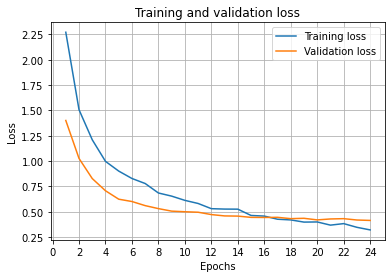

In [ ]:
loss = history.history['loss']
loss.insert(0, None)
val_loss = history.history['val_loss']
val_loss.insert(0, None)
epochs = range(len(loss))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc="upper right")
plt.grid()
plt.xticks(np.arange(0, len(loss), step=2))

loss.pop(0)
val_loss.pop(0)

# Uncomment below section to download chart
# plt.savefig("loss_chart.png", dpi=300)
# files.download("loss_chart.png")

### Plot training and validation accuracy per epoch

0

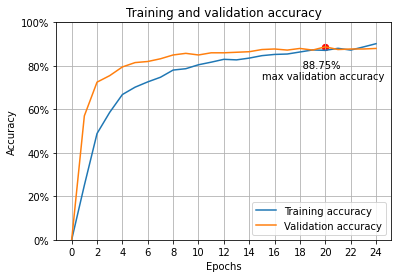

In [ ]:
accuracy = history.history['accuracy']
accuracy.insert(0, 0)
val_accuracy = history.history['val_accuracy']
val_accuracy.insert(0, 0)
epochs = range(len(accuracy))

plt.title('Training and validation accuracy')
plt.plot(epochs, accuracy, label='Training accuracy')
plt.ylabel('Accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.legend(loc="lower right")
plt.grid()
plt.ylim([0.0, 1.0])
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(np.arange(0, len(accuracy), step=2))

max_val_accuracy = max(val_accuracy)
max_val_accuracy_index = val_accuracy.index(max_val_accuracy)
max_val_accuracy_rounded = round(max_val_accuracy, 4) * 100.0


plt.scatter(max_val_accuracy_index, max_val_accuracy, s=40, marker='o', color='red')
plt.text(max_val_accuracy_index + -5, max_val_accuracy - 0.15, f'             {max_val_accuracy_rounded}%\nmax validation accuracy', fontsize=10)

accuracy.pop(0)
val_accuracy.pop(0)

# Uncomment below section to download chart
# plt.savefig("accuracy_chart.png", dpi=300)
# files.download("accuracy_chart.png")

## Export model

In [ ]:
!pip install tensorflowjs

     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 112kB 11.0MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


In [ ]:
import tensorflowjs as tfjs

tfjs.converters.save_keras_model(model, '/content/models/plant-check-model', weight_shard_size_bytes=300000000)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [ ]:
!du -h ./models/plant-check-model

93M	./models/plant-check-model


In [ ]:
!zip -r /content/models/plant-check-model.zip /content/models/plant-check-model

  adding: content/models/plant-check-model/ (stored 0%)
  adding: content/models/plant-check-model/group1-shard1of1.bin (deflated 7%)
  adding: content/models/plant-check-model/model.json (deflated 96%)


In [ ]:
from google.colab import files
files.download("/content/models/plant-check-model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>